# Visual Similarity - Get Embeddings
## The purpose of this notebook is to get embeddings for image data. We are going to use embeddings to run clustering algorithm.

# Import Libraries

In [7]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, iqr

In [8]:
import warnings
warnings.filterwarnings( "ignore")

In [9]:
!pip install opencv-python
!pip install boto3
!pip install torch
!pip install torchvision

In [10]:
!pip install tqdm

In [18]:
import cv2
import boto3
import urllib
from tqdm import tqdm
from PIL import Image
from transformers import ResNetModel
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import pickle

## Read images

In [12]:
import os 
import glob 

#Set the path where images are stored 
img_dir = "images/" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
images = []
# Read in all the images
for i in tqdm(range(len(files))): 
    img = cv2.imread(files[i]) 
    images.append(img)

100%|████████████████████████████████████| 15691/15691 [02:11<00:00, 119.01it/s]


In [13]:
print('Total images read: {}'.format(len(images)))

Total images read: 15691


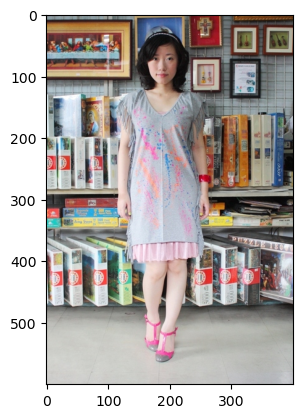

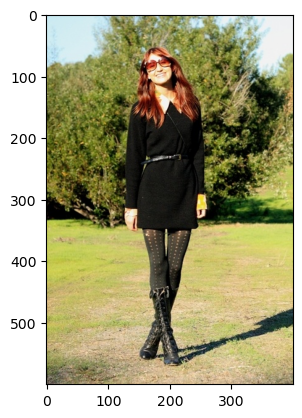

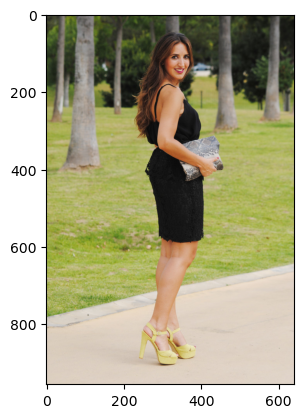

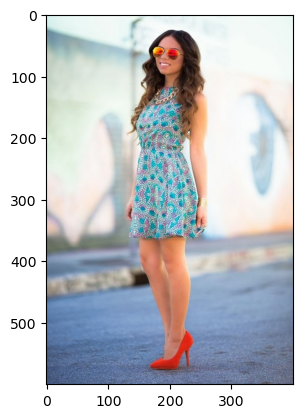

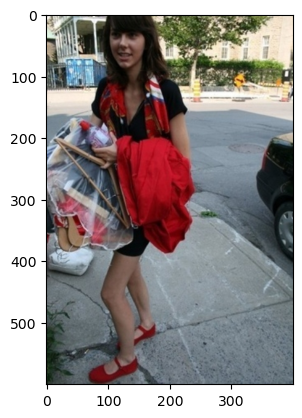

In [14]:
# Display sample 5 images
for img in images[:5]:
    plt.figure()
    plt.imshow(img)

# Get Vector embeddings

In [15]:
# Define class to get vector embeddings
class Img2Vec():
    
    def __init__(self, cuda = False, model = 'resnet50'):
        '''
        Params:
        cuda: If set to True, will run on GPU
        model: Name of requested model
        '''
        
        self.model_name = model
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((224, 224)),
                                             transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                  std = [0.229, 0.224, 0.225]
                                                                 )
                                            ]
                                           )
        
    def get_vec(self, img):
        '''
        Get vector embedding of input image
        '''
        img_transform = self.transform(img)
        if self.model_name == 'resnet50':
            model = ResNetModel.from_pretrained("microsoft/resnet-50")
            
        img_embedding = model(img_transform.unsqueeze(0)).pooler_output.squeeze()
        
        return img_embedding

In [16]:
img2vec = Img2Vec() #instantiate Img2Vec class
'''
Since it requires lot of memory to get vector embeddings for all images,
we are going to run this in batches
'''
vector_embeddings = []
        
subset_index = 158 #Index to get the batch of images 
images_subset = images[(subset_index-1) * 100:subset_index*100]
print('subset range: {}:{}'.format((subset_index-1) * 100, subset_index*100))

# Iterate over each image in the given batch
for i in tqdm(range(len(images_subset))):
    vector_embeddings.append(img2vec.get_vec(images_subset[i])) #get vector embeddings

#dump the given batch embeddings to local drive
with open('vector_embeddings_{}.pkl'.format(subset_index), 'wb') as fp:
    pickle.dump(vector_embeddings, fp)

# Reduce dimensionality using UMAP

We need to run dimensionality reduction because of two reasons:
- it's computationally expensive to run clustering on embeddings of size 2000
- to reduce bias and have more generalizable/robust clusters

In [20]:
# read all the batches of vector embeddings
vector_embeddings_list = []
for i in tqdm(range(1, 159)):
    with open('vector_embeddings_{}.pkl'.format(i), 'rb') as ip:
        my_embeddings = pickle.load(ip)
        vector_embeddings_list = vector_embeddings_list + my_embeddings

100%|████████████████████████████████████████| 158/158 [00:00<00:00, 240.66it/s]


In [56]:
# detach the tensor and get feature matrix of vector embeddings
X = [x.detach().tolist() for x in vector_embeddings_list]
X = np.array(X)
X[0]

array([0.        , 0.04808913, 0.01156724, ..., 0.03104787, 0.04170132,
       0.        ])

In [58]:
print('Total length of the vector: {}'.format(len(X[0])))

Total length of the vector: 2048


We are going to use UMAP to run dimensionality reduction. UMAP stands for Uniform Manifold Approximation and Projection which preserves the orignal structure in the data.

In [27]:
# install umap library
!pip install umap-learn

  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/d1/1b/46802a050b1c55d10c4f59fc6afd2b45ac9b4f62b2e12092d3f599286f14/umap_learn-0.5.6-py3-none-any.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/bf/06/18c0e17eb245b7caeb861f2ff747adb0575500183b6ec4282d5350d29e9f/pynndescent-0.5.12-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00


In [28]:
# import UMAP
from umap import UMAP

In [59]:
# run dimensionality reduction
# we are going to reduce the size of embeddings to 500.
reducer = UMAP(random_state=42, n_components = 500) #instantiate reducer to reduce the size of vector embeddings
embeddings = reducer.fit_transform(X) 

In [60]:
# dump the reduced vector embeddings
with open('reduced_embeddings.pkl', 'wb') as fp:
    pickle.dump(embeddings, fp)

In [62]:
# get length of vector embeddings
len(embeddings[0])

500

# Conclusion

Any machine learning algorithm requires numeric fearure representation of input data for it to process and learn the task it's been trained on. Vector embeddings for images is a well researched problem and there are quite a few popular solutions. We have used resnet-50 tog ect vector embeddings of images.

We also used UMAP to run dimensionality reduction to reduce the size of image vector embeddings. This will make it computationally less expensive and also make the clustering output to be more robust.